# Supervised Learning Project

## Project Description:

The telecom operator Interconnect would like to be able to forecast their churn of clients.

If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options.

Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

Our task is to build a model that will predict whether a customer is going to leave the company, using the provided data, which includes the data of customers taht already left the company.

## Data Description


The data consists of files obtained from different sources:

contract.csv — contract information
personal.csv — the client's personal data
internet.csv — information about Internet services
phone.csv — information about telephone services

# The work plan for the project

**The work plan for the final project will include**


1. reading all the libraries
2. loading the data
3. look at the data: 
- all four data frame have one unique key to them. 
  It is easier to merge all the data frames by the 
  key to use the features of all the four files.
  join all the data frames to one using the customerID to merge them all

4. analyzing the type of the features:
- checking the categorical features, how many option they have, is it numeric or strings.   
  - Are they mixed or the same type.
- We will be paying extra attention to missing values when joining the data sets.
    - if the missing value are targets, we cannot use it and delete the observation
    - if the missing value are features, examine if they can be replace with option that relate to lack of this     feature like 'No' or 0.
  - replacing the missing features with 'No'
  - replacing type 'object' to 'category'
  - replacing BeginDate from type 'object' type to datetime to be able to make manipulation on this feature.
5. replacing the datetime features with useful data that will help the model:
    - the exact date of joining is less important than the period of the customer is with the company. 
    Because the customers pay monthly, lets transform this data to calculate how many months the customers are customers for the company.

6. calculating the target
- we need to know if the customer left or continue with the company. We do so by checking the EndDate column, if EndDate is not equal to 'No'(left the company), then it is Yes(continues).
7. We now can remove the unnecessary columns:
    - customerID
    - BeginDate
    - EndDate
8. checking for duplicates
9. checking for imbalance data. If problem with imbalance data exist, we can address it by imblearn library objects.
    - we can try one of imblearn methods for oversampling (SMOTE) OR
    - try one of imblearn combined methods for oversampling and undersampling (SMOTE + Tomek or SMOTE + ENN)
    - we will have to check if addressing the imbalance problem giving better score.
10. show the features distribution
11. Deciding if we need to normalize the features, depend on the models we will choose. Some of the models doesn't need normalization.
12. use encoding for all the categorical features for models that need it. We will use OHE Encoding on the features that are categorical
13. Before addressing the imbalance problem, we will divide the data to features and target
14. Dividing the data between train and test
15. We will make two sets of train data:
    - without change
    - balance data

### Downloading the data

In [1]:
# standard imports and setup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# data preparation
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

# pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# machine learning models
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.utils import class_weight

# model evaluation
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

# ignore warnings
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")
        
%matplotlib inline
plt.style.use('seaborn')

In [2]:
# download the datasets
try:
    contract = pd.read_csv('contract.csv')
    personal = pd.read_csv('personal.csv')
    internet = pd.read_csv('internet.csv')
    phone = pd.read_csv('phone.csv')
except:   
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

## General info

In [3]:
# dictionery for iterations
dfs = {
    "contract" : contract,
    "personal" : personal,
    "internet" : internet,
    "phone" : phone
}

# show the first rows of the data 
for k,v in dfs.items():
    print(k)
    display(v.head())
    print('')

contract


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65



personal


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



internet


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



phone


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [4]:
# show the general info of the data 
for k,v in dfs.items():
    display(v.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

In [5]:
# unique values
for k,v in dfs.items():
    print(k)
    print('-'*len(k))
    for column in v.columns:
        print(column)
        print(v[column].unique())
    print('\n')

contract
--------
customerID
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
BeginDate
['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '2018-11-01' '2015-03-01' '2018-02-01'
 '2016-06-01' '201

### Observations:

* Contract and personal dataframes have 7043 rows.

* Internet dataframe has 5517 rows and phone dataset has 6361 rows, which can indicate that not all customers have both services.

* In the contract dataframe EndDate column has two types of inputs, dates or 'No'. We'll make a copy of this column and replace in the copy the 'No' with the last date (February 1, 2020). We'll create a new column Tenure which will be the difference between the copied EndDate and BeginDate.

* In contract dataframe we need to change the type of few columns (BeginDate to datetime object and TotalCharges to float).

* The dates in the EndDate column will be replaced with 'Yes'.

* All dates start on the first of the month so we'll replace the BeginDate column with BeginMonth and BeginYear.

* All dataframes has the customerID, we will merge all dataframes based on this column.

* In the merged dataframe we need to assure that all columns are UpperCamelCase (need to fix customerID and gender).

* There are many binary and categorical features, later on we'll encode them.

### Missing values and duplicates

In [6]:
#looking for missing values
for k,v in dfs.items():
    display(v.isna().sum())

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

customerID       0
MultipleLines    0
dtype: int64

For all the columns that have a lot of string values, we will check for empty strings as well.



In [7]:
# looking for emtpy strings
for k,v in dfs.items():
    display(v['customerID'].str.contains(' ').sum())

0

0

0

0

In [8]:
# looking for emtpy strings
contract['TotalCharges'].str.contains(' ').sum()

11

In [9]:
contract.loc[contract['TotalCharges'].str.contains(' ')]


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


### observations:

All customers who signed up on 2020-02-01 actually have the contract for less than a month and of course they have not yet been charged any fee, and since they are new customers, we will remove them from the dataset. For this purpose we need to assure that the indexes in personal and contract datasets are the same.

In [10]:
# check for index equlity
personal['customerID'].equals(contract['customerID'])

True

In [11]:
# remove new customers
personal.drop(contract[contract['TotalCharges'].str.contains(' ')].index, inplace=True)
contract.drop(contract[contract['TotalCharges'].str.contains(' ')].index, inplace=True)
# check if removed correctly
contract.loc[contract['TotalCharges'].str.contains(' ')]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges


In [ ]:
# looking for duplicated ids
for k,v in dfs.items():
    display(v['customerID'].duplicated().sum())

Now there are no missing values or duplicates!

### Converting to desired data types

In [13]:
# convert from object to datetime
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])

In [14]:
# convert from object to float
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

In [15]:
# check if converted correctly
contract.dtypes

customerID                  object
BeginDate           datetime64[ns]
EndDate                     object
Type                        object
PaperlessBilling            object
PaymentMethod               object
MonthlyCharges             float64
TotalCharges               float64
dtype: object

## Additional features

**We would like to add two features to the contract dataset:**

* Churn - Our target value (values of Yes/No). Based on a copy of the EndDate.
* Tenure - Number of days the customer has a contract with the company. It will be calculated as the difference between the EndDate and BeginDate.
* BeginMonth and BeginYear - All the dates begin with the first of the month, so we can refer only to the month and the year.

In [16]:
# create the target feature based on the EndDate column
contract['Churn'] = contract['EndDate'].copy()

In [17]:
# replace the 'No' values with the last valid date (2020-02-01)
contract['EndDate'].replace(to_replace = 'No', value = '2020-02-01', inplace = True)
# convert from object to datetime
contract['EndDate'] = pd.to_datetime(contract['EndDate'])

In [18]:
# create a new feature - Tenure
contract['Tenure'] = (contract['EndDate'] - contract['BeginDate']).dt.days

In [19]:
# replace the specified dates in the EndDate with 'Yes' for churned customers
contract.loc[~(contract.Churn == 'No'), 'Churn'] = 'Yes'

In [20]:
contract['BeginMonth'] = contract.BeginDate.dt.month
contract['BeginYear'] = contract.BeginDate.dt.year

### Merging the dataframes

In [21]:
data = personal.merge(contract, on='customerID', how='left')
data = data.merge(phone, on='customerID', how='left')
data = data.merge(internet, on='customerID', how='left')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,BeginMonth,BeginYear,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,...,1,2020,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,Male,0,No,No,2017-04-01,2020-02-01,One year,No,Mailed check,...,4,2017,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,...,10,2019,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),...,5,2016,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,...,9,2019,No,Fiber optic,No,No,No,No,No,No


In [22]:
print(f"Number of customres: {len(data)}")

Number of customres: 7032


In [23]:
# missing values in each column
data.isna().sum()

customerID             0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
Churn                  0
Tenure                 0
BeginMonth             0
BeginYear              0
MultipleLines        680
InternetService     1520
OnlineSecurity      1520
OnlineBackup        1520
DeviceProtection    1520
TechSupport         1520
StreamingTV         1520
StreamingMovies     1520
dtype: int64

### observation: 

- As a result of the mergings we got some rows that have NaN values for the phone and internet services. 

- We have 680 rows with missing values in the MultipleLines column, which refers to the phone service and 1520 missing values in the columns that refer to the internet services. 

- As the TotalCharges doesn't have missing values at all, we assume that they actually paying for some services. 

- We assume that there are customers that uses only one of the two services only phone service or only internet service.

In [24]:
print(f"Rows with missing values in one of the services: {len(data[data.isna().any(axis=1)])}")
display(data[data.isna().any(axis=1)][['MultipleLines','InternetService']].head())

Rows with missing values in one of the services: 2200


,MultipleLines,InternetService
0,NaN,DSL
3,NaN,DSL
7,NaN,DSL
11,No,NaN
16,No,NaN


There are 2200 rows with missing values in one of the services. We can see that those who don't have phone services, do have some internet services and vice versa. Also we can see that the sum of the missing values as we mentioned before, which we assume that can't accure simultaniusly is 1520 + 680 = 2200, the exact number of rows that we got now. For the information to be more clear we will create new columns that indicates if the customer has or not internet or phone services. In the original columns we will **replace those NaN values with 'No phone service' and 'No internet service'**. For the additional internet services we will replace the NaNs with 'No'.

In [25]:
data['MultipleLines'].fillna('No phone service', inplace = True)
data['InternetService'].fillna('No internet service', inplace = True)
data['HasPhone'] = data['MultipleLines'].replace(to_replace = {"No phone service": 0, "No": 1, "Yes":1})
data['HasInternet'] = data['InternetService'].replace(to_replace = {"No internet service": 0, "DSL":1, "Fiber optic":1})
data.fillna('No', inplace = True)

In [26]:
display(data['HasPhone'].value_counts(), data['HasInternet'].value_counts())

1    6352
0     680
Name: HasPhone, dtype: int64

1    5512
0    1520
Name: HasInternet, dtype: int64

In [27]:
# missing values in each column
data.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
Tenure              0
BeginMonth          0
BeginYear           0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
HasPhone            0
HasInternet         0
dtype: int64

### Investigating the unique end-dates

In [28]:
data.EndDate.unique()

array(['2020-02-01T00:00:00.000000000', '2019-12-01T00:00:00.000000000',
       '2019-11-01T00:00:00.000000000', '2019-10-01T00:00:00.000000000',
       '2020-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

There are 4 unique dates when customers left the services. 4 months in a row - October 2019 to January 2020. Information about new customer promotions, year-end specials, new companies entering the market, etc. would be helpful.

## EDA
****************************************************

First we want to see the distribution of our target variable.

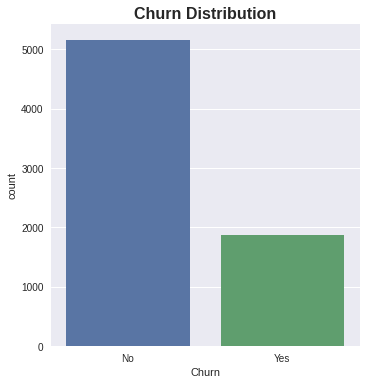

In [30]:
ax = sns.catplot(x="Churn", kind="count", data=data)
plt.title('Churn Distribution', weight='bold').set_fontsize('16');

As we can see our target is binary so our task is a binary classification, and the target is unblanced, we need to choose models that can handle this imbalance and choose the right metric

### Personal Information



**we'll plot some visualization of the relations between the personal information and churn.**

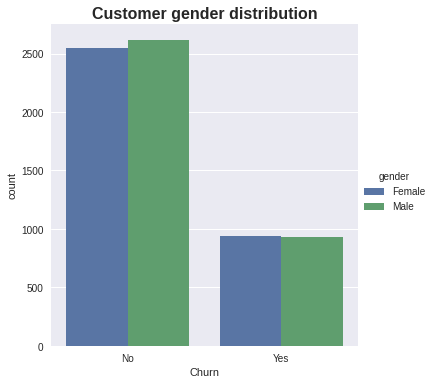

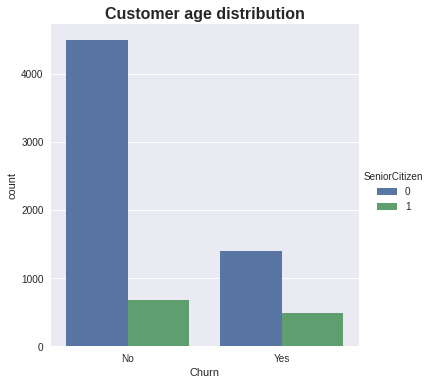

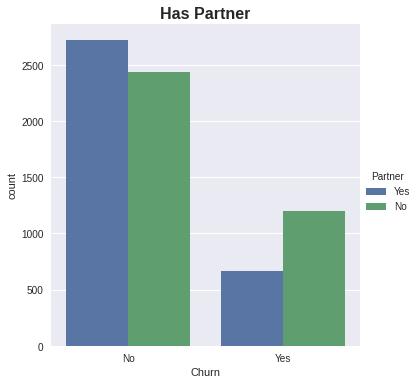

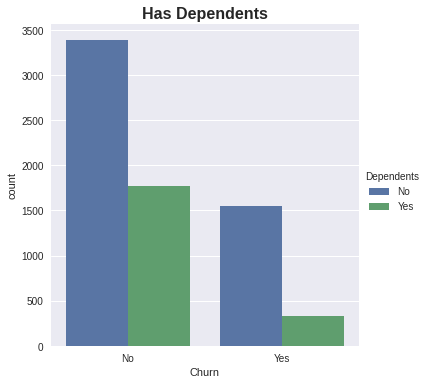

In [31]:
binary_features = {"gender" : "Customer gender distribution", 
                   "SeniorCitizen" : "Customer age distribution", 
                   "Partner" : "Has Partner", 
                   "Dependents" : "Has Dependents"}

# plot for all binary features
for k in binary_features:
    ax = sns.catplot(x="Churn", kind="count", data=data, hue = k)
    plt.title(binary_features[k], weight='bold').set_fontsize('16')
    plt.show();

- Gender - The churn rate is similar for both genders.

- SeniorCitizen - Despite having a small percentage out of all customers, senior citizens have a much higher churn rate. This means that churn is higher for senior citizens.

- Partner - Customers who have no partners are more likely to churn.

- Dependents - Customers who have no dependents are more likely to churn.

### Account Information

we'll plot some visualization of the relations between the account information and churn.

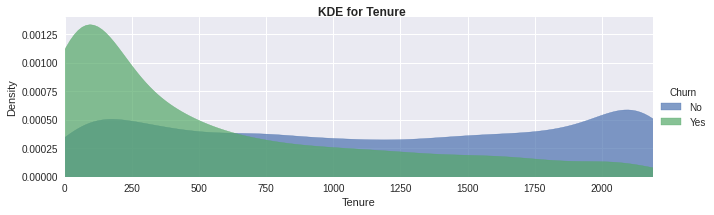

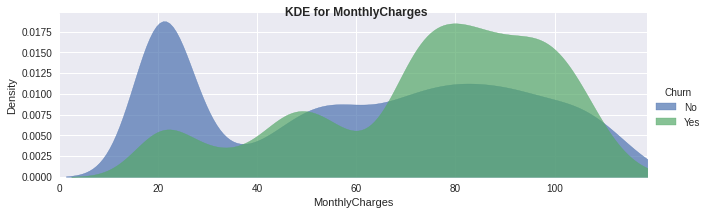

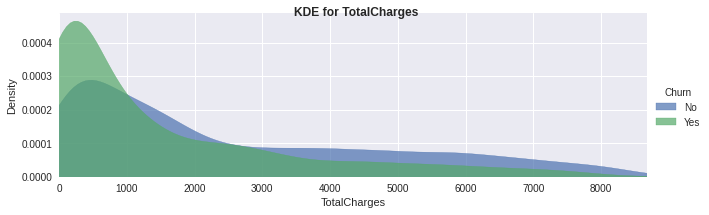

In [33]:
continues_features = ["Tenure", "MonthlyCharges", "TotalCharges"]
for item in continues_features:  
    s = sns.FacetGrid(data, hue = 'Churn', aspect = 3)
    s.map(sns.kdeplot, item, shade = True, alpha = 0.7)
    s.set(xlim=(0, data[item].max()))
    s.add_legend()
    s.set_axis_labels(item, 'Density')
    s.fig.suptitle(f"KDE for {item}", weight='bold')
    plt.show()

In [34]:
data.groupby('Churn')[['Tenure','MonthlyCharges','TotalCharges']].median()

,Tenure,MonthlyCharges,TotalCharges
Churn,,,
No,1157,64.45,1683.60
Yes,304,79.65,703.55


- Tenure - The median tenure for customers who have left is around 10 months (304 days), which means that recent clients are more likely to churn.

- MonthlyCharges - Monthly charges for customers who have left are usually higher and are around 80.

- TotalCharges - The median total charges of customers who have churned is very low, what correlates with the low tenure.

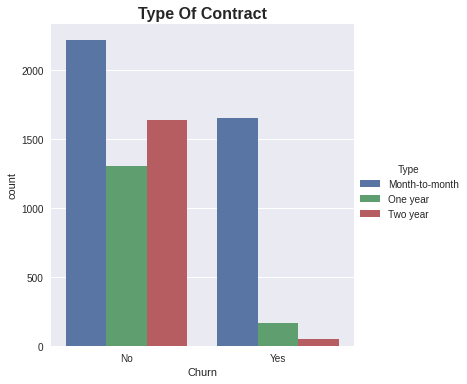

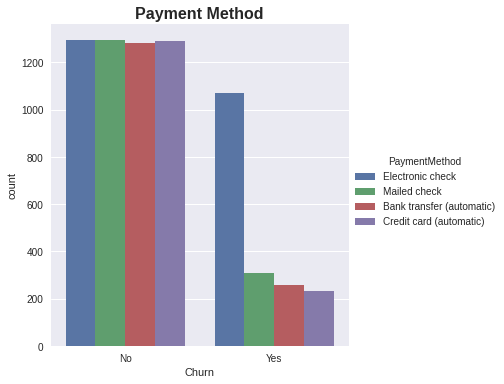

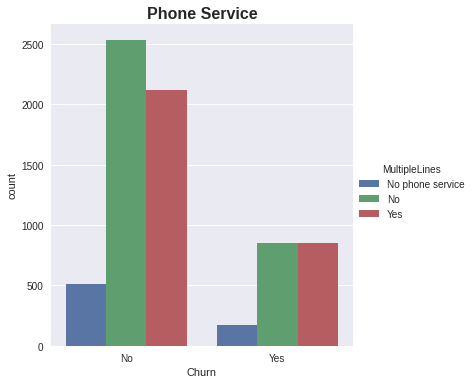

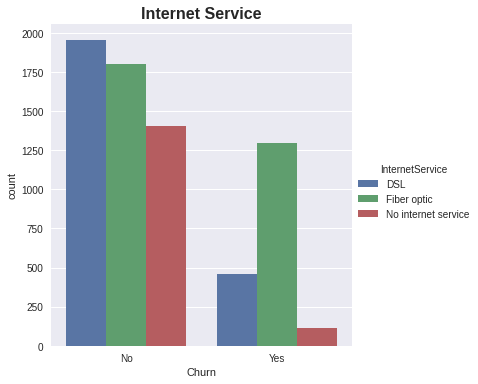

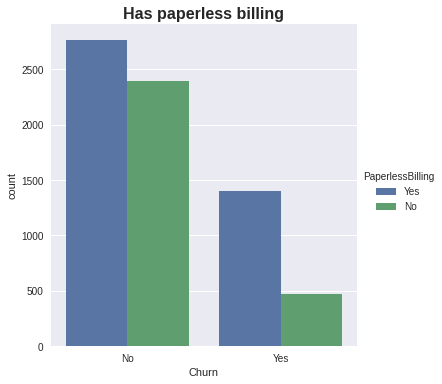

In [35]:
categorical_features = {"Type" : "Type Of Contract",
                        "PaymentMethod" : "Payment Method",
                        "MultipleLines" : "Phone Service",
                        "InternetService" : "Internet Service",
                        "PaperlessBilling" : "Has paperless billing"}

# plot for all categorical features
for k in categorical_features:
    ax = sns.catplot(x="Churn", kind="count", data=data, hue = k)
    plt.title(categorical_features[k], weight='bold').set_fontsize('16')
    plt.show();

- Type - In contrast to Customers on one or two year contracts, customers on monthly subscriptions are more likely to churn.

- PaymentMethod - Customers who have electronic check payment method are more likely to churn.

- MultipleLines -

- InternetService - Churn rate is much higher for customers with Fiber optic internet services.

- PaperlessBilling - Customers who have paperless billing are more likely to churn.

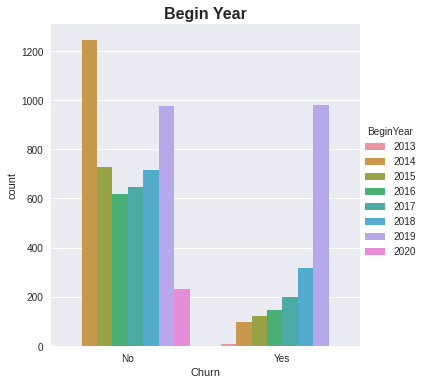

In [37]:
ax = sns.catplot(x="Churn", kind="count", data=data, hue = "BeginYear")
plt.title("Begin Year", weight='bold').set_fontsize('16')
plt.show();

- BeginYear - The majority of customers who churned the company were those who signed up for its services in 2019.

### Additional services used by the customer

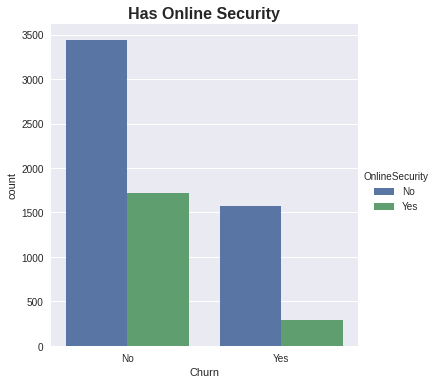

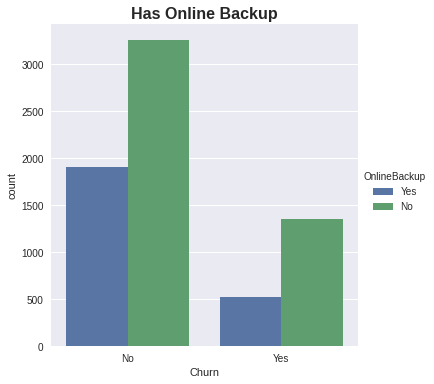

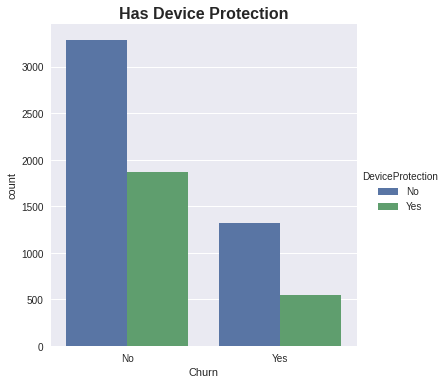

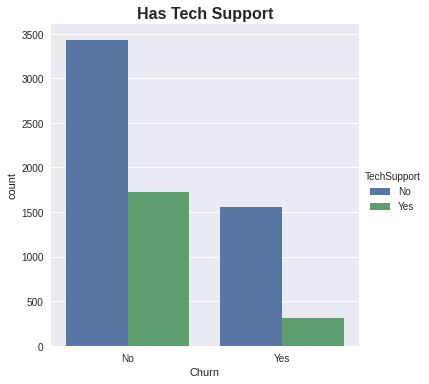

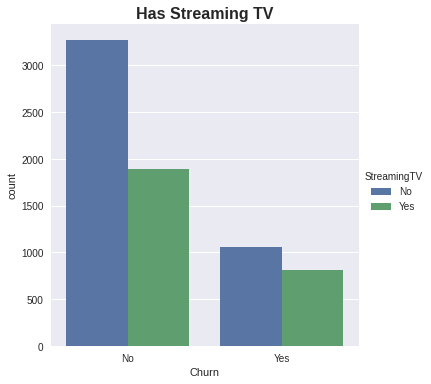

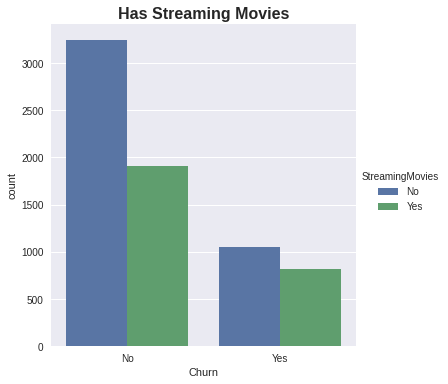

In [38]:
binary_features = {"OnlineSecurity" : "Has Online Security", 
                   "OnlineBackup" : "Has Online Backup", 
                   "DeviceProtection" : "Has Device Protection", 
                   "TechSupport" : "Has Tech Support",
                   "StreamingTV" : "Has Streaming TV",
                   "StreamingMovies" : "Has Streaming Movies"}

# plot for all binary features
for k in binary_features:
    ax = sns.catplot(x="Churn", kind="count", data=data, hue = k)
    plt.title(binary_features[k], weight='bold').set_fontsize('16')
    plt.show();

- OnlineSecurity - Customers who have no online security service are more likely to churn.

- OnlineBackup - Customers who have no online backup service are more likely to churn.

- DeviceProtection - Customers who have no device protection service are more likely to churn.

- TechSupport - Customers who have no tech support service are more likely to churn.

- StreamingTV - Customers with a Streaming TV service are more likely to churn.

- StreamingMovies - Customers with a Streaming Movies service are more likely to churn.

### Correlations between features and target

For revealing the correlation of the categorical fatures with the target, we'll make a copy of the data and make some manipulations based on the results of the graphs above. Binary features will be converted to numeric values of 0 and 1. Categorical features will get the values in the ordere that were shown in the graphs.

In [40]:
data_copy = data.copy()


In [41]:
# list of binary features
binary_features = ["OnlineSecurity", "OnlineBackup" , "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies",
                   "Partner" , "Dependents" , "PaperlessBilling", "Churn"]

In [42]:
# encode the strings to numeric values
for f in binary_features:
    data_copy[f].replace(to_replace = {"Yes": 1, "No": 0}, inplace = True)

In [43]:
data_copy.gender.replace(to_replace = {"Male" : 0, "Female" : 1}, inplace = True)
data_copy.Type.replace(to_replace = {"Month-to-month" : 0, "One year" : 1, "Two year" : 2}, inplace = True)
data_copy.PaymentMethod.replace(to_replace = {"Electronic check" : 0, "Mailed check": 1, 
                                                 "Bank transfer (automatic)":2, "Credit card (automatic)":3}, inplace = True)
data_copy.MultipleLines.replace(to_replace = {"No phone service": 0, "No": 1, "Yes" : 2}, inplace = True)
data_copy.InternetService.replace(to_replace = {"No internet service" : 0, "DSL" :1, "Fiber optic" : 2}, inplace = True)

In [44]:
# find the correlations of the target with the features
churn_corr = data_copy.corr()['Churn'].sort_values(ascending = False)

In [45]:
# assign the red color for negative values and green for positive values
colors = ['red' if x < 0 else 'green' for x in churn_corr]

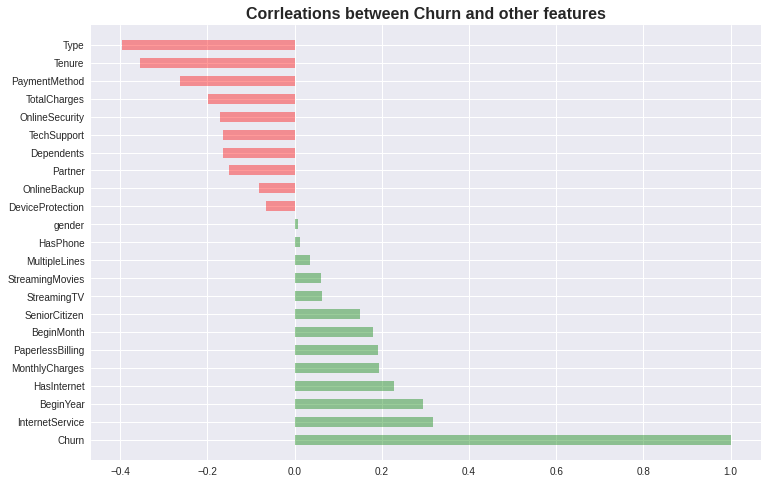

In [46]:
# plot the correlations
plt.figure(figsize=(12,8))
plt.hlines(y = churn_corr.index, xmin = 0, xmax= churn_corr, color = colors, alpha = 0.4, linewidth = 10);
plt.title('Corrleations between Churn and other features', weight='bold').set_fontsize('16');

**observation:**
    
Based on our analysis, we see that the following features are most correlated with the target: InternetService, BeginYear, HasInternet, Type, Tenure, PaymentMethod and TotalCharges.
*************************************************************************

Now we want to see the correlations between the features themselves, and if there high correlation between the features, we will drop few of them.

In [48]:
data_copy[['Churn', 'InternetService', 'BeginYear', 'HasInternet', 'Type', 'Tenure','PaymentMethod', 'TotalCharges']].corr()

,Churn,InternetService,BeginYear,HasInternet,Type,Tenure,PaymentMethod,TotalCharges
Churn,1.000000,0.316350,0.293770,0.227578,-0.396150,-0.354496,-0.262918,-0.199484
InternetService,0.316350,1.000000,-0.055959,0.825625,-0.288855,0.031119,-0.178655,0.428212
BeginYear,0.293770,-0.055959,1.000000,-0.055637,-0.654961,-0.987425,-0.326365,-0.819304
HasInternet,0.227578,0.825625,-0.055637,1.000000,-0.241574,0.037417,-0.117927,0.374878
Type,-0.396150,-0.288855,-0.654961,-0.241574,1.000000,0.676787,0.359487,0.450306
Tenure,-0.354496,0.031119,-0.987425,0.037417,0.676787,1.000000,0.340997,0.825811
PaymentMethod,-0.262918,-0.178655,-0.326365,-0.117927,0.359487,0.340997,1.000000,0.222694
TotalCharges,-0.199484,0.428212,-0.819304,0.374878,0.450306,0.825811,0.222694,1.000000


### observation

As we can see, there is a high correlation between Tenure and BeginYear because it was calculated based on it, so we'll drop both cloumns, BeginYear and BeginMonth to avoid data leakage.